# Summarize Runs
Find the best model

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from ase import units
import pandas as pd
import numpy as np
import json

## Gather outputs from runs
Get the configuration and test summary

In [2]:
complete_runs = [x.parent for x in Path('runs').glob('*/test_summary.json')]
print(f'Found {len(complete_runs)} completed runs')

Found 23 completed runs


In [3]:
def load_summary(path: Path) -> dict:
    """Load the summary of the run configuration and parameters
    
    Args:
        path: Path to the run
    Returns:
        Summary of inputs and results
    """
    
    # Load the configuration and summary
    output = {'path': path}
    output.update(json.loads((path / 'config.json').read_text()))
    output.update(json.loads((path / 'test_summary.json').read_text()))
    output['delta_energy'], output['delta_force'] = output['huber_deltas']
    
    # Get the best validation loss
    output['valid_force_loss'] = pd.read_csv(path / 'train_log.csv')['valid_loss_force'].min()
    return output

In [4]:
summary = pd.DataFrame(map(load_summary, complete_runs)).sort_values('force_rmse')
summary.head()

,path,huber_deltas,num_epochs,batch_size,learning_rate,lr_patience,energy_weight,max_force,test_runtime,energy_mae,force_rmse,delta_energy,delta_force,valid_force_loss
10,runs/n512-lr3.0e-05-5c927961,"[0.1, 10.0]",512,32,0.00003,64,0.1,10,14.007253,0.001308,0.077744,0.1,10.0,0.006239
2,runs/n256-lr3.0e-05-c095cb60,"[0.1, 10.0]",256,32,0.00003,64,0.1,10,14.074899,0.000448,0.088534,0.1,10.0,0.007686
13,runs/n128-lr3.0e-05-abd69233,"[0.1, 10.0]",128,32,0.00003,64,0.1,10,14.454809,0.000513,0.100429,0.1,10.0,0.009148
7,runs/n64-lr3.0e-05-86759595,"[0.1, 10.0]",64,32,0.00003,64,0.1,10,15.086174,0.000779,0.114694,0.1,10.0,0.011150
14,runs/n32-lr3.0e-05-0d256c8f,"[0.1, 10.0]",32,32,0.00003,64,0.1,10,15.382138,0.000711,0.127094,0.1,10.0,0.013151


## Evaluate the learning parameters
We need a low learning rate for fine tuning, but too low prevents adaquate learning. The effect of learning rate being too high appears in the first few epochs, so we'll do this test with only 8 epochs.

In [5]:
cutoff_subset = summary.query('num_epochs==8 and lr_patience==8').sort_values('learning_rate')

Text(0, 0.5, 'Force, RMSD (eV/$\\AA$)')

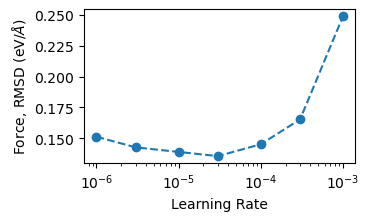

In [6]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.semilogx(cutoff_subset['learning_rate'], cutoff_subset['force_rmse'], '--o')

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Force, RMSD (eV/$\\AA$)')

Check if we can do better with learning rate patience

In [7]:
subset = summary.query('num_epochs==16 and learning_rate==3e-5 and delta_force==10').sort_values('lr_patience')

Text(0, 0.5, 'Force, RMSD (eV/$\\AA$)')

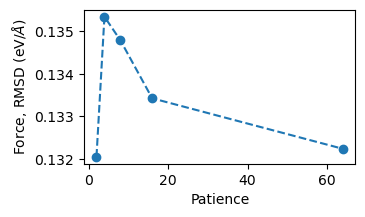

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.plot(subset['lr_patience'], subset['force_rmse'], '--o')

ax.set_xlabel('Patience')
ax.set_ylabel('Force, RMSD (eV/$\\AA$)')

I don't trust the low patience (2) enough to ignore the trend of "more patience is better." I'm going to use a patience of 64 in the long-scale runs.

Check to make sure we don't overfit on the number of epochs

In [9]:
subset = summary.query('learning_rate==3e-5 and delta_force==10 and lr_patience==64').sort_values('num_epochs')

Text(0, 0.5, 'Force, RMSD (eV/$\\AA$)')

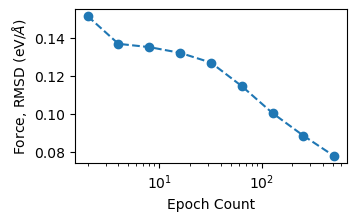

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.semilogx(subset['num_epochs'], subset['force_rmse'], '--o')

ax.set_xlabel('Epoch Count')
ax.set_ylabel('Force, RMSD (eV/$\\AA$)')

Text(0, 0.5, 'Test Loss')

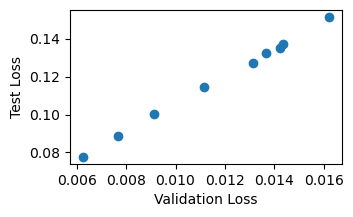

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.plot(subset['valid_force_loss'], subset['force_rmse'], 'o')

ax.set_xlabel('Validation Loss')
ax.set_ylabel('Test Loss')

## Learning Curve
Figure out if we've completly converged wrt to number of epochs

In [12]:
best = summary.sort_values('force_rmse').iloc[0]
best

path                runs/n512-lr3.0e-05-5c927961
huber_deltas                         [0.1, 10.0]
num_epochs                                   512
batch_size                                    32
learning_rate                            0.00003
lr_patience                                   64
energy_weight                                0.1
max_force                                     10
test_runtime                           14.007253
energy_mae                              0.001308
force_rmse                              0.077744
delta_energy                                 0.1
delta_force                                 10.0
valid_force_loss                        0.006239
Name: 10, dtype: object

In [13]:
log = pd.read_csv(best.path / 'train_log.csv')

Text(0, 0.5, 'Loss')

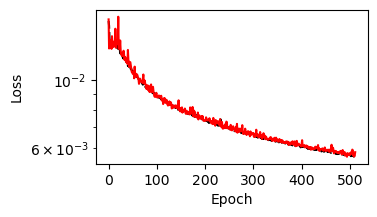

In [14]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.semilogy(log['epoch'], log['train_loss_total'], '--k')
ax.semilogy(log['epoch'], log['valid_loss_total'], '-r')


ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

We don't finish converging even past 32 epochs. Need to set up a longer run

## Plot the Learning Data
Get an idea of what level of errors to expect

In [15]:
test_data = pd.read_csv(best.path / 'test_records.csv.gz').sort_values('n_atoms')
print(f'Loaded {len(test_data)} test records')

Loaded 10083 test records


Show the predicted vs actual

In [16]:
true_forces = np.concatenate(test_data['force_true'].apply(json.loads).apply(np.ravel))

In [17]:
ml_forces = np.concatenate(test_data['force_ml'].apply(json.loads).apply(np.ravel))

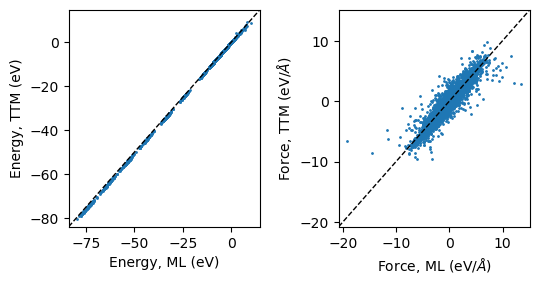

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(5.5, 3.))

# Energy plot
axs[0].scatter(test_data['energy_ml'], test_data['energy_true'], s=1)
axs[0].set_xlabel('Energy, ML (eV)')
axs[0].set_ylabel('Energy, TTM (eV)')

# Force plot
m = axs[1].scatter(ml_forces, true_forces, s=1)
axs[1].set_xlabel('Force, ML (eV/$\\AA$)')
axs[1].set_ylabel('Force, TTM (eV/$\\AA$)')

for ax in axs:
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', lw=1)

fig.tight_layout()

## Save path to best model
Get the model location 

In [19]:
best_path = Path('best_model')
if best_path.exists():
    best_path.unlink()

In [20]:
best_path.symlink_to(best.path)